In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from sklearn.linear_model import LinearRegression

import backtrader as bt
import pandas as pd 
import backtrader.feeds as btfeed
import statsmodels.tsa.stattools as ts


import os.path
import sys

import datetime

import matplotlib.pyplot as plt

In [ ]:
class Strategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

                
class dataFeed(btfeed.GenericCSVData):
    params = (
        ('dtformat', '%Y%m%d'),
        ('tmformat', '%H%M%S'),
        ('datetime', 0),
        ('time', 1),
        ('open', 2),
        ('high', 3),
        ('low', 4),
        ('close', 5),
        ('volume', 6),
        ('openinterest', -1),
    )
    
cerebro = bt.Cerebro()

#datas path

datapath1 = 'C:\\Users\\Senya\\Trading\\SBER_180801_190119.csv'
datapath2 = 'C:\\Users\\Senya\\Trading\\SBERP_180801_190119.csv'


data1 = dataFeed(dataname=datapath1)
data2 = dataFeed(dataname=datapath2)

cerebro.adddata(data1, name="comm")
cerebro.adddata(data2, name="pref")

cerebro.addstrategy(Strategy)
####
#Broker
cerebro.broker.setcash(100000.0)
cerebro.broker.setcomission(comission=2, margin=True)

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


In [ ]:
cerebro.plot()

In [2]:
#common stocks preprocessing
df_common = pd.read_csv('SBER_180801_190119_h.csv')

df_common.rename(columns={'<DATE>':'DATE', '<TIME>': 'TIME'}, inplace=True)
df_common.TIME = df_common.TIME.astype(str)
df_common.DATE = df_common.DATE.astype(str)

df_common['DATE'] = pd.to_datetime(df_common.DATE + df_common.TIME, format = "%Y%m%d%H%M%S")
df_common.set_index(pd.DatetimeIndex(df_common['DATE']), inplace=True)
df_common.drop(columns=['TIME','DATE'],inplace = True)

In [3]:
#Pref. stocks preprpcessing
df_pref = pd.read_csv('SBERP_180801_190119_h.csv')

df_pref.rename(columns={'<DATE>':'DATE', '<TIME>': 'TIME'}, inplace=True)
df_pref.TIME = df_pref.TIME.astype(str)
df_pref.DATE = df_pref.DATE.astype(str)

df_pref['DATE'] = pd.to_datetime(df_pref.DATE+df_pref.TIME, format = "%Y%m%d%H%M%S")
df_pref.set_index(pd.DatetimeIndex(df_pref['DATE']), inplace=True)
df_pref.drop(columns=['TIME','DATE'],inplace = True)


In [4]:
s1 = df_pref.loc[:,'<CLOSE>'].rename('close_pref')
s2 = df_common.loc[:,'<CLOSE>'].rename('close_common')
df_close = pd.concat([s1,s2], axis=1)

In [5]:
pref_ind = df_pref.index
com_ind = df_common.index
s2.drop(com_ind.difference(pref_ind), inplace=True)
print(com_ind.difference(pref_ind))

DatetimeIndex(['2018-08-01 13:20:00', '2018-08-07 13:15:00',
               '2018-10-10 12:00:00', '2018-10-10 15:40:00',
               '2018-10-16 13:30:00', '2018-10-16 13:40:00',
               '2018-10-18 13:55:00', '2018-10-25 14:15:00'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [ ]:
plt.figure(figsize=(15,9))
ax1 = df_close.close_pref.plot(color='blue', grid=True, label='pref close')
ax2 = df_close.close_common.plot(color='red', grid=True,  label='common close')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)

In [ ]:
spread = s2-s1

plt.figure(figsize=(13,5))

ax1 = pd.DataFrame(spread).plot(color='blue', grid=True, label = 'Spread')
ax2 = rolling.plot(color='red')


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.axhline(y=spread.mean(), color='r', linestyle='-')

plt.legend(h1+h2, l1+l2, loc=2)



In [ ]:
rolling = pd.concat([spread,pd.DataFrame([spread[:i+1].mean() for i in range(len(spread))], index=spread.index)], axis=1)

In [6]:
class coint_df_test:
    
    def __init__(self, close_1, close_2): # close_1, close_2 - must be pandas.Series
        self.close_1 = close_1
        self.close_2 = close_2
    
    def df_tests(self):
        lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
        lr.fit(self.close_1.values.reshape(-1,1), self.close_2.values)
        y_hat1 = lr.coef_ * self.close_1 + lr.intercept_
        res1 = self.close_2 - y_hat1
        result1 = ts.adfuller(res1, 1)
        lr.fit(self.close_2.values.reshape(-1,1), self.close_1.values)
        y_hat2 = lr.coef_ * self.close_2 + lr.intercept_
        res2 = self.close_1 - y_hat2
        result2 = ts.adfuller(res2, 1)
        
        if (result1 < result2):
            self.spread = res1
        else:
            self.spread = res2
            
    def get_spread(self):
        return self.spread
    
    

In [7]:
cft = coint_df_test(s1, s2)
cft.df_tests()

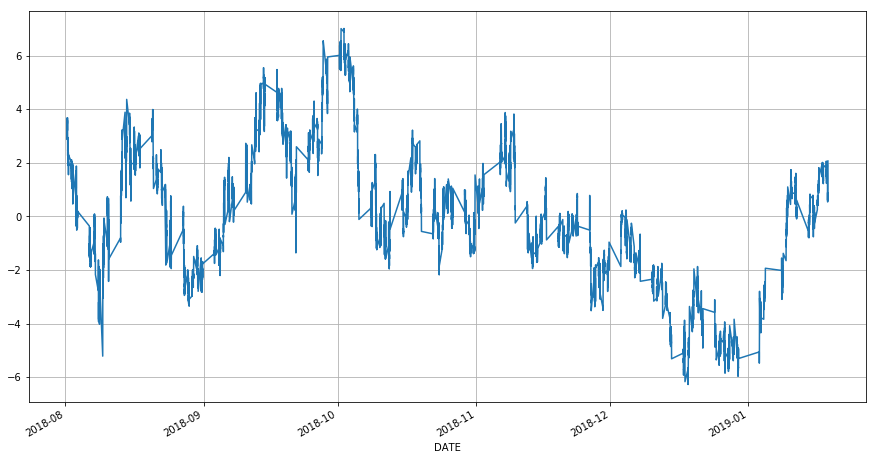

In [12]:
spread = cft.get_spread()
spread.plot(grid=True, figsize=(15,8))